        City    Datetime  PM2.5   PM10     NO   NO2    NOx   NH3    CO   SO2  \
0      Delhi  2015-01-01  153.3  241.7  182.9  33.0   81.3  38.5  1.87  64.5   
1     Mumbai  2015-01-01   70.5  312.7  195.0  42.0  122.5  31.5  7.22  83.8   
2    Chennai  2015-01-01  174.1  275.4   56.2  68.8  230.9  28.5  8.56  60.8   
3    Kolkata  2015-01-01  477.2  543.9   14.1  76.4  225.9  45.6  2.41  42.1   
4  Bangalore  2015-01-01  171.6  117.7  123.3  12.4   61.9  49.7  1.26  79.7   

      O3  Benzene  Toluene  Xylene    AQI    AQI_Bucket  
0   83.6    18.93    20.81    8.32  204.5        Severe  
1  108.0     2.01    19.41    2.86   60.9  Satisfactory  
2   43.9    19.07    10.19    9.63  486.5        Severe  
3  171.1     9.31    11.65    9.39  174.4     Very Poor  
4  164.3     6.04    12.74    9.59  489.7          Good  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18265 entries, 0 to 18264
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      ----

C:\Users\acer\AppData\Local\Temp\ipykernel_18140\2207085291.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['AQI_Bucket'].fillna(df['AQI_Bucket'].mode()[0], inplace=True)


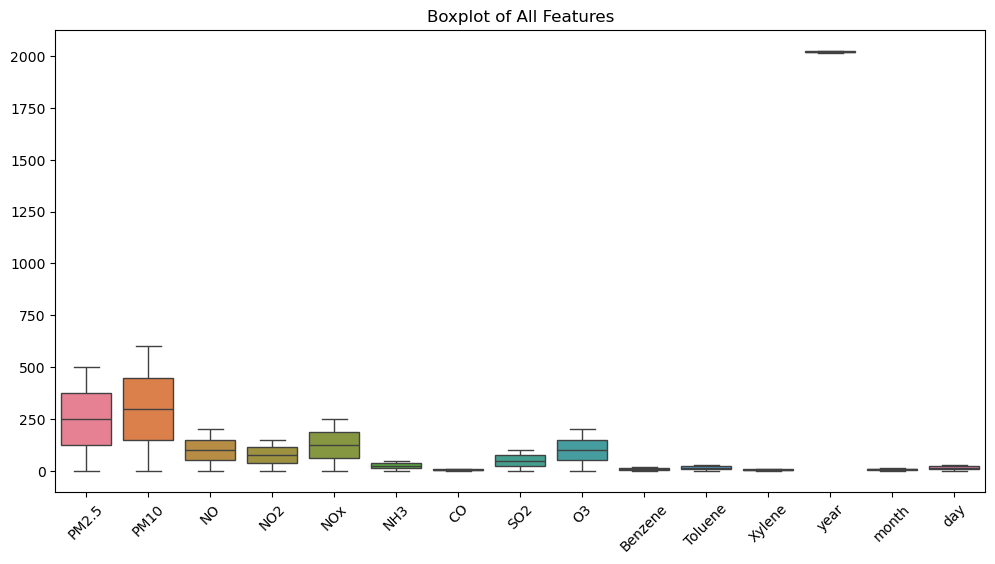


Best Parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Accuracy: 0.3438

Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.36      0.35      1239
           1       0.15      0.27      0.20       589
           2       0.50      0.36      0.42      1825

    accuracy                           0.34      3653
   macro avg       0.33      0.33      0.32      3653
weighted avg       0.39      0.34      0.36      3653



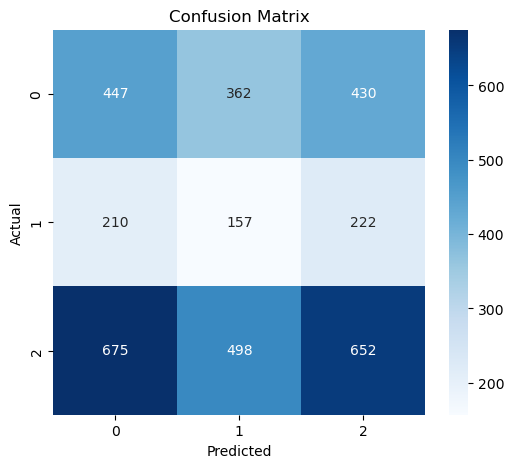


City-wise Accuracy:
        City  Accuracy
0      Delhi  0.866411
1     Mumbai  0.867780
2    Chennai  0.868601
3    Kolkata  0.864769
4  Bangalore  0.876266


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# =============================
# 1️⃣ Load dataset
# =============================
df = pd.read_csv("city_day.csv")  # replace with your path
print(df.head())
print(df.info())

# =============================
# 2️⃣ Preprocessing
# =============================
# Convert Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Handle missing values
df.fillna(df.mean(numeric_only=True), inplace=True)
df['AQI_Bucket'].fillna(df['AQI_Bucket'].mode()[0], inplace=True)

# Optional: simplify AQI_Bucket for balanced classes
def bucketize_aqi(x):
    if x in ['Good', 'Satisfactory']:
        return 'Good'
    elif x in ['Moderate']:
        return 'Moderate'
    else:
        return 'Poor'

df['AQI_Bucket'] = df['AQI_Bucket'].apply(bucketize_aqi)

# Encode AQI_Bucket to numeric labels
le = LabelEncoder()
df['AQI_Bucket_Label'] = le.fit_transform(df['AQI_Bucket'])

# =============================
# 3️⃣ Feature Engineering
# =============================
df['year'] = df['Datetime'].dt.year
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

# Features and target
features = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene','year','month','day']
target = 'AQI_Bucket_Label'

# =============================
# 4️⃣ EDA (Boxplot)
# =============================
plt.figure(figsize=(12,6))
sns.boxplot(data=df[features])
plt.title("Boxplot of All Features")
plt.xticks(rotation=45)
plt.show()

# =============================
# 5️⃣ Train-Test Split
# =============================
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================
# 6️⃣ Feature Scaling
# =============================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================
# 7️⃣ Handle Class Imbalance
# =============================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# =============================
# 8️⃣ KNN Model + Hyperparameter Tuning
# =============================
param_grid = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform','distance'],
    'p': [1,2]
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)

# =============================
# 9️⃣ Evaluation
# =============================
acc = accuracy_score(y_test, y_pred)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# =============================
# 10️⃣ City-wise Accuracy (Optional)
# =============================
results = []
for city in df['City'].unique():
    city_data = df[df['City']==city]
    X_city = city_data[features]
    y_city = city_data[target]
    
    X_city_scaled = scaler.transform(X_city)
    y_city_pred = best_knn.predict(X_city_scaled)
    
    acc_city = accuracy_score(y_city, y_city_pred)
    results.append({'City': city, 'Accuracy': acc_city})

results_df = pd.DataFrame(results)
print("\nCity-wise Accuracy:")
print(results_df)
